In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

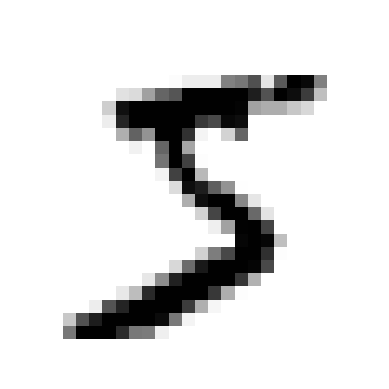

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

# plt.imshow is to display an image
# cmap = mpl.cm.binary: https://matplotlib.org/3.1.0/_images/sphx_glr_colormaps_003.png
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = 'nearest') #  interpolation is a process of determining the unknown values that lie in between the known data points.
#interpolation='nearest' simply displays an image without trying to interpolate between pixels if the display resolution is not the same as the image resolution


plt.axis('off') # https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
plt.show

In [6]:
y[0]

'5'

In [7]:
# label is string.... Needs to convert it into integer

import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
###### The classifier will return true if the given features belongs to class 5 else will return false

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### 1. Measuring Accuracy Using Cross-Validation

In [13]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)     #  StartifiedKFolds produce folds that contain a representative ratio of each class

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(len(train_index))
    print(len(test_index))

40000
20000
40000
20000
40000
20000


In [15]:
# Using sklearn cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
# Now checking the dumb classifier accuracy
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [17]:
np.zeros((len(X_train), 1), dtype = bool)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

### 2. Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
y_train_perfect_predictions = y_train_5         # Pretend we reach perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3. Precision and Recall

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)     # 3530 / (3530+687)
# correct only 83.7% of the time

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)       # 3530 / (3530+1891)
#only detects 65.1% of the 5s

0.6511713705958311

In [29]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision Recall Tradeoff

In [32]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [34]:
threshold = 0         #default threshold for sgd classifier is also 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [35]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [36]:
# How to decide which threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")  # to get the scores of all instances in the training set

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [47]:
# ploting precision and recall as functions of the threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])  

In [49]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

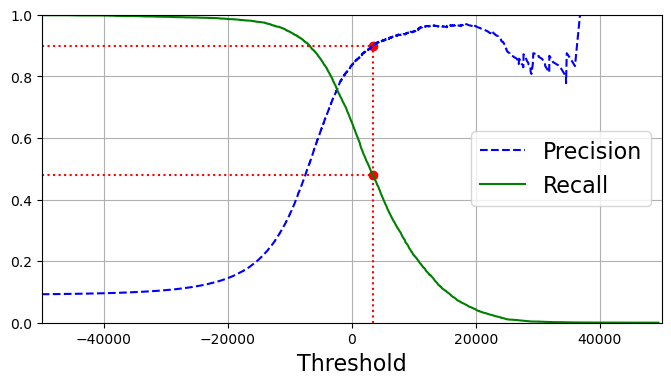

In [51]:
plt.figure(figsize=(8, 4))                                                                  
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

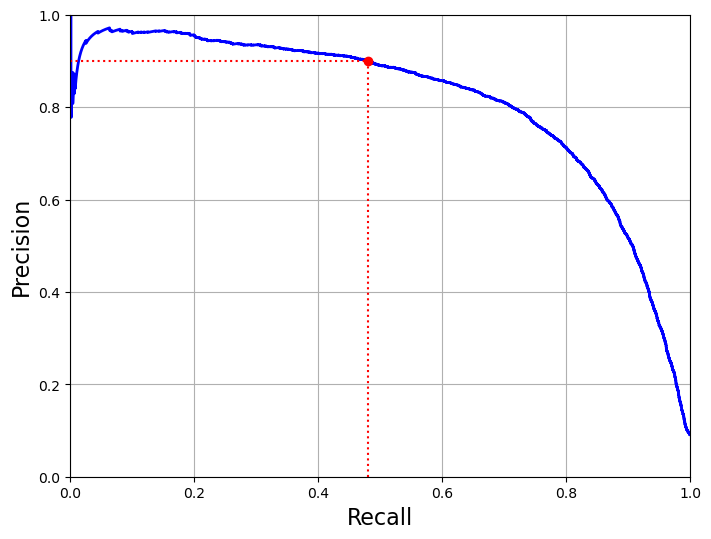

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [54]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

3370.0194991439557

In [55]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [57]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [58]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706